In [165]:
import pyspark as ps
import pprint
import json
from pyspark.sql.types import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
plt.style.available

['seaborn-dark-palette',
 'tableau-colorblind10',
 'seaborn-darkgrid',
 'fivethirtyeight',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-whitegrid',
 'seaborn-white',
 '_classic_test',
 'seaborn-notebook',
 'bmh',
 'grayscale',
 'classic',
 'fast',
 'seaborn-ticks',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-talk',
 'ggplot',
 'Solarize_Light2',
 'seaborn',
 'seaborn-muted',
 'seaborn-bright',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [3]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('casestudy-twitter')
         .getOrCreate()
        )
sc = spark.sparkContext

In [4]:
sc

<SparkContext master=local[4] appName=casestudy-twitter>

In [5]:
spark

In [9]:
!pwd

/home/jovyan/work/tweet-spark/data/info


In [10]:
rdd = (sc.textFile('/home/jovyan/work/tweet-spark/data/french_tweets.json')
          
      )

In [11]:
rdd.take(2)


['{"created_at":"Wed Apr 26 13:30:45 +0000 2017","id":857225437122097152,"id_str":"857225437122097152","text":"Je comprends pas trop la fin de 13 reasons why \\ud83d\\ude13","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/iphone\\" rel=\\"nofollow\\"\\u003eTwitter for iPhone\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":3137428743,"id_str":"3137428743","name":"TA\\u00cfNA\\u2661","screen_name":"tainabmn","location":null,"url":null,"description":null,"protected":false,"verified":false,"followers_count":318,"friends_count":406,"listed_count":2,"favourites_count":777,"statuses_count":3251,"created_at":"Sun Apr 05 16:03:00 +0000 2015","utc_offset":null,"time_zone":null,"geo_enabled":true,"lang":"fr","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","profile_background_image_url":"http:\

In [12]:
json.loads(rdd.first())

{'created_at': 'Wed Apr 26 13:30:45 +0000 2017',
 'id': 857225437122097152,
 'id_str': '857225437122097152',
 'text': 'Je comprends pas trop la fin de 13 reasons why 😓',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 3137428743,
  'id_str': '3137428743',
  'name': 'TAÏNA♡',
  'screen_name': 'tainabmn',
  'location': None,
  'url': None,
  'description': None,
  'protected': False,
  'verified': False,
  'followers_count': 318,
  'friends_count': 406,
  'listed_count': 2,
  'favourites_count': 777,
  'statuses_count': 3251,
  'created_at': 'Sun Apr 05 16:03:00 +0000 2015',
  'utc_offset': None,
  'time_zone': None,
  'geo_enabled': True,
  'lang': 'fr',
  'contributors_enabled': False,
  'is_translator': False,
  'profile_background_color

In [14]:
def string_to_json(string):
    try:
        return json.loads(string)
    except:
        return 0
    

In [56]:

        
def get_columns(row):
    try:
        return (row['id_str'], row['created_at'], 
                row['favorite_count'],
                row['quoted_status']['favorite_count'],
                row['text'], 
                row['user']['id_str'], 
                row['user']['name'], 
                row['place']['name'], 
                row['place']['country_code'],
                row['place']['bounding_box']['coordinates'][0][0][1],
                row['place']['bounding_box']['coordinates'][0][0][0])
    except: 
        return 0
    
        
        
        
rdd1 = (rdd.map(string_to_json)
           .filter(lambda x: x != 0))  

In [57]:
rdd2 = rdd1.map(get_columns).filter(lambda x: x != 0)


In [58]:
rdd2.take(1)

[('857225444831240193',
  'Wed Apr 26 13:30:47 +0000 2017',
  0,
  16,
  "La macronie En Marche ! commence déjà à s'écharper avant d'avoir commencé :\n\nhttps://t.co/9f4YhjMFaG",
  '273524713',
  'VIAL Pierre',
  'Gréoux-les-Bains',
  'FR',
  43.718485,
  5.781315)]

In [63]:
def casting_function(row):
    (tweet_id, time, favorite_counts, qc ,tweet_text, user_id, user_name, place, country ,cor1, cor2) = row
    return (tweet_id, time, int(favorite_counts),int(qc),tweet_text, user_id, user_name, place, country ,float(cor1), float(cor2))


trans = rdd2.map(casting_function)

In [64]:
trans.take(1)

[('857225444831240193',
  'Wed Apr 26 13:30:47 +0000 2017',
  0,
  16,
  "La macronie En Marche ! commence déjà à s'écharper avant d'avoir commencé :\n\nhttps://t.co/9f4YhjMFaG",
  '273524713',
  'VIAL Pierre',
  'Gréoux-les-Bains',
  'FR',
  43.718485,
  5.781315)]

In [67]:
schema_test = StructType( [
    StructField('tweet_id',     StringType(), True),
    StructField('time',  StringType(), True),
    StructField('favorite_counts',  IntegerType(), True),
    StructField('quoted_counts',  IntegerType(), True),
    StructField('tweet_text',  StringType(), True),
    StructField('user_id',  StringType(), True),
    StructField('user_name',  StringType(), True),
    StructField('place',  StringType(), True),
    StructField('country',  StringType(), True),
    StructField('longitude', FloatType(), True),
    StructField('latitude', FloatType(), True)
])

In [92]:
df = spark.createDataFrame(trans, schema_test)

In [69]:
df.createOrReplaceTempView('tweets')

In [70]:
df2 = spark.sql("""
SELECT count(*)
  FROM tweets
  where quoted_counts >100
""")

In [71]:
df2.show()

+--------+
|count(1)|
+--------+
|    7480|
+--------+



In [72]:
df2.printSchema()

root
 |-- count(1): long (nullable = false)



In [73]:
top_tweeters = spark.sql("""
SELECT user_id, user_name, count(*) as total
  FROM tweets
 GROUP BY user_id,
          user_name
 ORDER BY total DESC
""")

In [74]:
top_tweeters.show()

+------------------+-------------------+-----+
|           user_id|          user_name|total|
+------------------+-------------------+-----+
|        2645880732|      Ayoub LaFarge|  199|
|        3041669279|                 🙄|  191|
|        1108882074|              stacy|  177|
|         559888628|              Acram|  176|
|        4054325373|    Princesse Kebab|  176|
|        2589701544|           Fujito🐭|  153|
|         527361798|              vic ♡|  140|
|703624667626672128|           miłość ♡|  139|
|        2498837641|                 💸|  134|
|        2213796670|           Alexis🔰|  130|
|        2577810058|         rashoumon.|  124|
|         493443899|     carole lemaire|  110|
|823601516737101824|MARTMAS MARTIN 🇫🇷|  104|
|        2151547656|Jɪᴍɪɴ 내사랑 💆🏻🌹|  100|
|        3930216495|          idn n idc|   98|
|        2851499375|          dead soul|   98|
|         373264785|             Cécile|   98|
|        2148176331|   ANASEOK IS OTP ♡|   93|
|         601142831|     

In [76]:
##Emmanuel Macron and Marine Le Pen 

query2 = '''
SELECT user_id, user_name,
COUNT(tweet_id) as Total_tweet, 
SUM(CASE WHEN (tweet_text LIKE '%Emmanuel%' OR tweet_text LIKE '%emmanuel%' OR tweet_text LIKE '%Macron%' OR tweet_text LIKE '%macron%') THEN 1 ELSE 0 END) AS count_emmanual,
SUM(CASE WHEN (tweet_text LIKE '%Marine%' OR tweet_text LIKE '%marine%' OR tweet_text LIKE '%Le Pen%' OR tweet_text LIKE '%le pen%') THEN 1 ELSE 0 END) AS count_marine
FROM tweets
GROUP BY user_id, user_name
ORDER BY count_emmanual DESC, count_marine DESC
'''


In [77]:
df2 = spark.sql(query2)

In [78]:
df2.show()

+------------------+--------------------+-----------+--------------+------------+
|           user_id|           user_name|Total_tweet|count_emmanual|count_marine|
+------------------+--------------------+-----------+--------------+------------+
|        3245436977|     Laura Biancheri|         28|            19|           7|
|747514010707320832|         Corona75009|         50|            15|          23|
|         130481825|Cyrille [No Rotonde]|         35|            15|           1|
|         373088455|       Uberstitution|         42|            15|           0|
|        1080786871|       Didus Ineptus|         79|            14|           6|
|820221265512374272|AdelineC FN84 circo4|         16|            13|           5|
|833319607142346752|           Romuald B|         64|            12|          11|
|          89541537|           Françoise|         62|            11|          23|
|          96295783|Dubitatif 71🇫🇷🇺🇸|         32|            11|           0|
|737031927216099328|

In [81]:
count = spark.sql('''SELECT COUNT(*) FROM tweets''')
count.show()

+--------+
|count(1)|
+--------+
|   25968|
+--------+



In [82]:
unique_user_id = spark.sql('''SELECT COUNT(DISTINCT user_id) FROM tweets''')
unique_user_id.show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                   7279|
+-----------------------+



In [83]:
query4 = '''
SELECT SUM(CASE WHEN a.count_emmanual > a.count_marine THEN 1 ELSE 0 END) AS emmanual,
SUM(CASE WHEN a.count_emmanual < a.count_marine THEN 1 ELSE 0 END) AS marine,
COUNT(1)
FROM (SELECT * FROM tweets1 WHERE count_emmanual != 0 OR count_marine != 0) AS a'''

In [84]:
df4 = spark.sql(query4)
df4.show()

+--------+------+--------+
|emmanual|marine|count(1)|
+--------+------+--------+
|     345|   144|     528|
+--------+------+--------+



In [79]:
df2.createOrReplaceTempView('tweets1')

In [80]:
query3 = '''
SELECT COUNT(*) AS interest_in_politic
FROM tweets1
WHERE count_emmanual != 0 OR count_marine != 0'''

df3 = spark.sql(query3)
df3.show()

+-------------------+
|interest_in_politic|
+-------------------+
|                528|
+-------------------+



In [112]:
new_df = spark.sql("""
SELECT tweet_id, user_id,user_name,place, longitude, latitude, tweet_text,
       CASE WHEN tweet_text rLIKE '[Mm]acron' THEN 1 ELSE 0 END AS E_count,
       CASE WHEN tweet_text rLIKE '[Ll]e [Pp]en' THEN 1 ELSE 0 END as M_count
  FROM tweets
""")

In [113]:
new_df.createOrReplaceTempView('tweets1')

In [114]:
new_df.show()

+------------------+------------------+--------------------+--------------------+---------+---------+--------------------+-------+-------+
|          tweet_id|           user_id|           user_name|               place|longitude| latitude|          tweet_text|E_count|M_count|
+------------------+------------------+--------------------+--------------------+---------+---------+--------------------+-------+-------+
|857225444831240193|         273524713|         VIAL Pierre|    Gréoux-les-Bains|43.718487| 5.781315|La macronie En Ma...|      1|      0|
|857225468659068929|         914331169|  doublevé-haine-bae|  Bonneuil-sur-Marne|48.756695| 2.471827|Il  bégaye comme ...|      0|      0|
|857225470206758913|         599128359|              Freddy|             Avroult| 50.61706| 2.124123|.@MaitreGims alor...|      0|      0|
|857225535923126275|         559888628|               Acram|         Survilliers|49.091446| 2.530875|Je supporte pas c...|      0|      0|
|857225601635274752|       

In [118]:
df2 = spark.sql("""
SELECT user_id, user_name, COUNT(tweet_text) as total_tweets, SUM(E_count) as total_E, SUM(M_count) as total_M
  FROM tweets1
 GROUP BY user_id, user_name
 
 ORDER BY total_tweets DESC, total_E DESC, total_M DESC

""")

In [119]:
df2.show()

+------------------+-------------------+------------+-------+-------+
|           user_id|          user_name|total_tweets|total_E|total_M|
+------------------+-------------------+------------+-------+-------+
|        2645880732|      Ayoub LaFarge|         199|      1|      1|
|        3041669279|                 🙄|         191|      0|      0|
|        1108882074|              stacy|         177|      2|      0|
|        4054325373|    Princesse Kebab|         176|      0|      2|
|         559888628|              Acram|         176|      0|      1|
|        2589701544|           Fujito🐭|         153|      2|      0|
|         527361798|              vic ♡|         140|      0|      0|
|703624667626672128|           miłość ♡|         139|      1|      0|
|        2498837641|                 💸|         134|      1|      0|
|        2213796670|           Alexis🔰|         130|      1|      1|
|        2577810058|         rashoumon.|         124|      0|      0|
|         493443899|    

In [93]:
p_df = df.toPandas()

In [94]:
p_df.head(5)

,tweet_id,time,favorite_counts,quoted_counts,tweet_text,user_id,user_name,place,country,longitude,latitude
0,857225444831240193,Wed Apr 26 13:30:47 +0000 2017,0,16,La macronie En Marche ! commence déjà à s'écha...,273524713,VIAL Pierre,Gréoux-les-Bains,FR,43.718487,5.781315
1,857225468659068929,Wed Apr 26 13:30:52 +0000 2017,0,51,Il bégaye comme un petit qui s'est fait voler...,914331169,doublevé-haine-bae,Bonneuil-sur-Marne,FR,48.756695,2.471827
2,857225470206758913,Wed Apr 26 13:30:53 +0000 2017,0,2,".@MaitreGims alors on joue les divas, on se pr...",599128359,Freddy,Avroult,FR,50.617062,2.124123
3,857225535923126275,Wed Apr 26 13:31:08 +0000 2017,0,86,Je supporte pas ce genre de personnes https://...,559888628,Acram,Survilliers,FR,49.091446,2.530875
4,857225601635274752,Wed Apr 26 13:31:24 +0000 2017,0,1,&gt; all the #knitters say #ThankYou to you f ...,86313409,jacquie rinaldi,South West,GB,49.882473,-6.368504


In [122]:
p_df['Macron'] = p_df['tweet_text'].str.contains(r'([Ee]mmanuel|[Mm]acron)')*1
p_df['Le Pen'] = p_df['tweet_text'].str.contains(r'([Mm]arine|[Ll]e [Pp]en)')*1

In [123]:
p_df.head(1)

,tweet_id,time,favorite_counts,quoted_counts,tweet_text,user_id,user_name,place,country,longitude,latitude,Macron,Le Pen
0,857225444831240193,Wed Apr 26 13:30:47 +0000 2017,0,16,La macronie En Marche ! commence déjà à s'écha...,273524713,VIAL Pierre,Gréoux-les-Bains,FR,43.718487,5.781315,1,0


In [139]:
p_df['date'] = p_df['time'].str.split().str[1:3]
p_df['year'] = p_df['time'].str.split().str[-1]

In [140]:
# the data was gathered during april 27 to 29
p_df['date'].value_counts()

[Apr, 27]    11865
[Apr, 28]    10064
[Apr, 26]     3655
[Apr, 29]      384
Name: date, dtype: int64

In [147]:
p_df['day'] = p_df['date'].str[1]

In [142]:
# only data's year is 2017
p_df['year'].value_counts()

2017    25968
Name: year, dtype: int64

In [143]:
p_df.shape

(25968, 15)

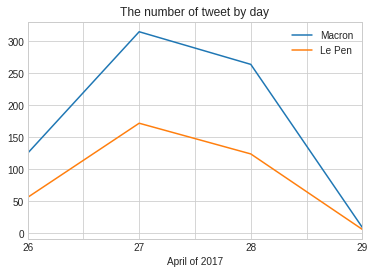

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
p_df.groupby('day').agg({'Macron' : 'sum', 'Le Pen': 'sum'}).plot()
plt.title("The number of tweet by day")
plt.xlabel("April of 2017")
plt.savefig("pic.png")

In [149]:
# select only tweets that mentioned either "Macron" or "Le Pen"
p_df_subset = p_df[(p_df['Macron']>0) |(p_df['Le Pen']>0)]

In [150]:
p_df_subset.shape

(1010, 16)

In [152]:
geometry = [Point(xy) for xy in zip(p_df['latitude'], p_df['longitude'])]
geo_df = gpd.GeoDataFrame(p_df, crs='crs', geometry=geometry)



In [169]:
geo_df

,tweet_id,time,favorite_counts,quoted_counts,tweet_text,user_id,user_name,place,country,longitude,latitude,Macron,Le Pen,date,year,day,geometry
0,857225444831240193,Wed Apr 26 13:30:47 +0000 2017,0,16,La macronie En Marche ! commence déjà à s'écha...,273524713,VIAL Pierre,Gréoux-les-Bains,FR,43.718487,5.781315,1,0,"[Apr, 26]",2017,26,POINT (5.78131 43.71849)
1,857225468659068929,Wed Apr 26 13:30:52 +0000 2017,0,51,Il bégaye comme un petit qui s'est fait voler...,914331169,doublevé-haine-bae,Bonneuil-sur-Marne,FR,48.756695,2.471827,0,0,"[Apr, 26]",2017,26,POINT (2.47183 48.75669)
2,857225470206758913,Wed Apr 26 13:30:53 +0000 2017,0,2,".@MaitreGims alors on joue les divas, on se pr...",599128359,Freddy,Avroult,FR,50.617062,2.124123,0,0,"[Apr, 26]",2017,26,POINT (2.12412 50.61706)
3,857225535923126275,Wed Apr 26 13:31:08 +0000 2017,0,86,Je supporte pas ce genre de personnes https://...,559888628,Acram,Survilliers,FR,49.091446,2.530875,0,0,"[Apr, 26]",2017,26,POINT (2.53087 49.09145)
4,857225601635274752,Wed Apr 26 13:31:24 +0000 2017,0,1,&gt; all the #knitters say #ThankYou to you f ...,86313409,jacquie rinaldi,South West,GB,49.882473,-6.368504,0,0,"[Apr, 26]",2017,26,POINT (-6.36850 49.88247)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,858183652219420672,Sat Apr 29 04:58:21 +0000 2017,0,112,Pour éviter les délocalisation #Le7MaiJeVoteMa...,3141038440,Raphael Goiset,Poids-de-Fiole,FR,46.580887,5.605082,0,1,"[Apr, 29]",2017,29,POINT (5.60508 46.58089)
25964,858183993182883840,Sat Apr 29 04:59:42 +0000 2017,0,20,Quel ignominie ce principe de projet Pour Les ...,784045065920479233,Que vive la verité,Méry-sur-Oise,FR,49.031673,2.144700,0,0,"[Apr, 29]",2017,29,POINT (2.14470 49.03167)
25965,858184056252616708,Sat Apr 29 04:59:57 +0000 2017,0,360,Le FN na pas besoin des insoumis! Il a le sout...,2394255489,#mb,Paris,FR,48.815521,2.224101,0,0,"[Apr, 29]",2017,29,POINT (2.22410 48.81552)
25966,858184213710995457,Sat Apr 29 05:00:35 +0000 2017,0,436,La réalité va vite rattraper Monsieur le sous-...,273524713,VIAL Pierre,Gréoux-les-Bains,FR,43.718487,5.781315,0,0,"[Apr, 29]",2017,29,POINT (5.78131 43.71849)


In [153]:
geometry[:3]

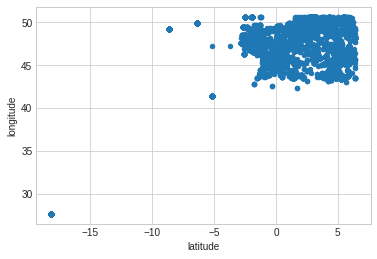

In [156]:
p_df.plot(x='latitude', y='longitude', kind='scatter')

In [157]:
!pwd

/home/jovyan/work/tweet-spark/data/info


In [163]:
street_map = gpd.read_file('/home/jovyan/work/tweet-spark/data/FRA_ADM0.shp',SHAPE_RESTORE_SHX=True)

In [175]:
street_map_1 = gpd.read_file('/home/jovyan/work/tweet-spark/data/fr_1km.shp')

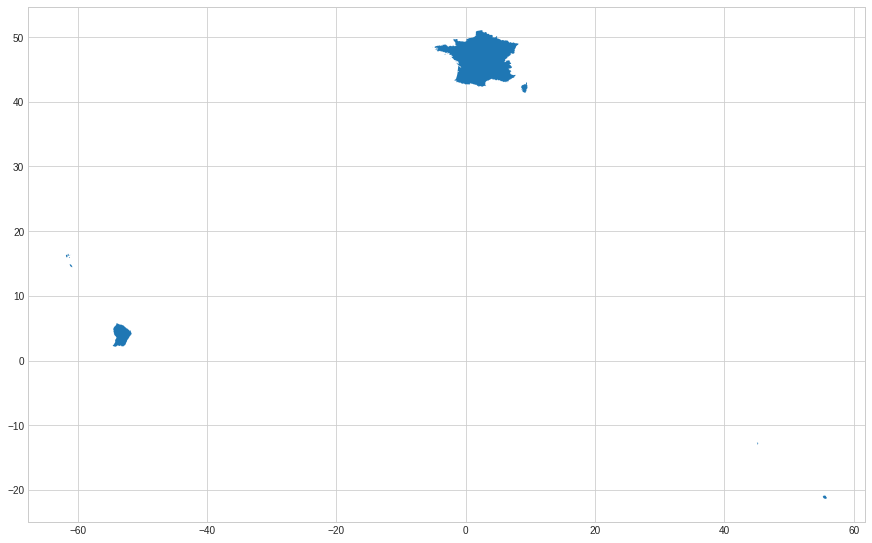

In [166]:
fig, ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax=ax)

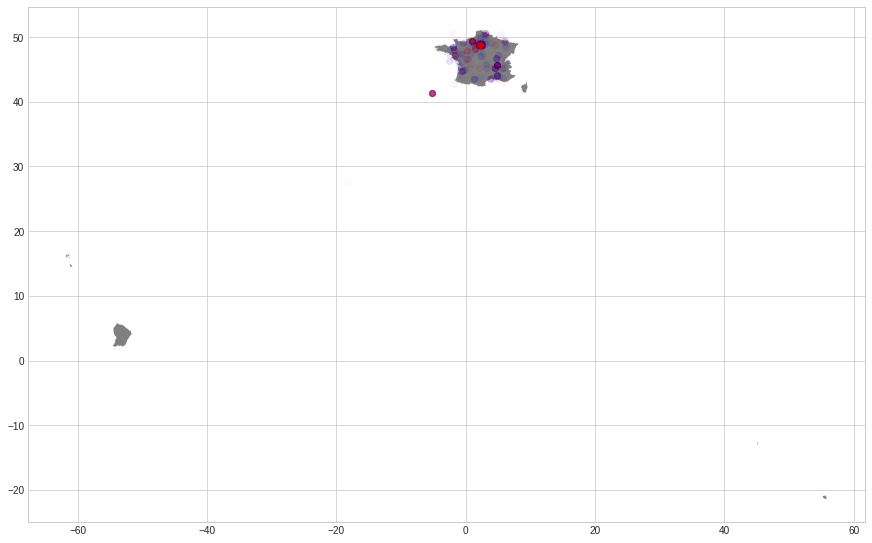

In [172]:
fig, ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax = ax, alpha = 1, color='grey')
geo_df[geo_df['Macron']==1].plot(ax=ax, color="blue", label = 'E_count', alpha = 0.02)
geo_df[geo_df['Le Pen']==1].plot(ax=ax, color="red", label = 'M_count', alpha = 0.02)
plt.savefig('map.png')

